<a href="https://colab.research.google.com/github/dantepawn/Convolutional-Neural-Network/blob/master/Load_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import pandas as pd
import numpy as np
import tensorflow as tf

# CSV

In [0]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

In [0]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


In [0]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

In [0]:
train_ds = tf.data.experimental.make_csv_dataset(
    train_file_path,
    16,
    label_name = LABEL_COLUMN,
    num_epochs = 1

)

In [0]:
test_ds = tf.data.experimental.make_csv_dataset(
    test_file_path,
    16,
    label_name = LABEL_COLUMN,
    num_epochs = 1

)

In [0]:
for batch , label in train_ds.take(1):
  for key , value in batch.items():
    print(value.numpy())

[b'male' b'female' b'male' b'male' b'male' b'female' b'male' b'female'
 b'male' b'male' b'male' b'female' b'male' b'female' b'male' b'male']
[28.  30.  28.  31.  20.5 17.  61.  34.  22.  16.  57.  28.  26.  21.
 23.  38. ]
[0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  7.75   106.425    7.8958  10.5      7.25    12.       6.2375  13.
   9.35     9.5     12.35    23.25     8.6625  77.9583  13.       7.05  ]
[b'Third' b'First' b'Third' b'Second' b'Third' b'Second' b'Third'
 b'Second' b'Third' b'Third' b'Second' b'Third' b'Third' b'First'
 b'Second' b'Third']
[b'unknown' b'unknown' b'unknown' b'unknown' b'unknown' b'unknown'
 b'unknown' b'unknown' b'unknown' b'unknown' b'unknown' b'unknown'
 b'unknown' b'D' b'unknown' b'unknown']
[b'Queenstown' b'Cherbourg' b'Southampton' b'Southampton' b'Southampton'
 b'Cherbourg' b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Queenstown' b'Queenstown' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
[

In [0]:
def get_dataset(file_path , **kwargs):

  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

In [0]:
raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

In [0]:
# see what you getting
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

In [0]:
show_batch(raw_train_data)

sex                 : [b'male' b'male' b'male' b'female' b'female']
age                 : [22. 50. 18. 31. 35.]
n_siblings_spouses  : [0 1 1 1 1]
parch               : [0 0 1 1 0]
fare                : [ 7.125  55.9    20.2125 26.25   83.475 ]
class               : [b'Third' b'First' b'Third' b'Second' b'First']
deck                : [b'unknown' b'E' b'unknown' b'unknown' b'C']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'n' b'n' b'n' b'n']


In [0]:
 # function will pack together all the columns
 def pack(features , label):
   return tf.stack(list(features.values()) , axis = -1)  , label 
   

# Continuous Features
integrate the preprocessing like normalization into the network , creating a layer that does that.

In [0]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']

In [0]:
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]

In [0]:
temp_dataset = get_dataset(train_file_path, 
                           select_columns=SELECT_COLUMNS,
                           column_defaults = DEFAULTS)

In [0]:
show_batch(temp_dataset)

age                 : [28. 25. 31. 28.  9.]
n_siblings_spouses  : [1. 1. 0. 0. 3.]
parch               : [0. 2. 2. 0. 2.]
fare                : [ 15.5    151.55   164.8667   0.      27.9   ]


In [0]:
# General class that selects numeric values and packs them into a single column.

class PackNumericalFeat():
  def __init__(self, names):
    self.names = names 

  def __call__(self , features , labels):
    numerical_feature = [features.pop(n) for n in self.names]
    numerical_feature = [tf.cast(f , tf.float32) for f in numerical_feature]
    numerical_feature = tf.stack(numerical_feature , axis = -1)
    features['numeric'] = numerical_feature 
    return features , labels  



In [0]:
NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

In [0]:
packed_train_data = raw_train_data.map(PackNumericalFeat(NUMERIC_FEATURES))

In [0]:
show_batch(packed_train_data)

sex                 : [b'female' b'male' b'male' b'female' b'male']
class               : [b'Third' b'Third' b'Second' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'n' b'y' b'y' b'y']
numeric             : [[18.      0.      0.      9.8417]
 [16.      4.      1.     39.6875]
 [28.      0.      0.      0.    ]
 [24.      0.      0.     13.    ]
 [33.      0.      0.      9.5   ]]


In [0]:
# extract mean from numerical to normilize

In [0]:
import pandas as pd

In [0]:
describtion = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()

In [0]:
MEAN  = describtion.loc['mean']
STD = describtion.loc['std']

In [0]:
def normalize_numeric_data(data , mean , std):
  return (data-mean)/std


In [0]:
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)


In [0]:
numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
numeric_columns

[NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7f90383a2e18>, mean=age                   29.631308
n_siblings_spouses     0.545455
parch                  0.379585
fare                  34.385399
Name: mean, dtype: float64, std=age                   12.511818
n_siblings_spouses     1.151090
parch                  0.792999
fare                  54.597730
Name: std, dtype: float64))]

In [0]:
numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)


In [0]:
example_batch , labels_batch  = next(iter(packed_train_data))

In [0]:
numeric_layer(example_batch).numpy() ## normalize the example batch to see if it works

array([[-1.6489457 ,  3.0011094 ,  2.0434003 , -0.05696939],
       [-0.0504569 , -0.47385937, -0.4786705 , -0.4557955 ],
       [-2.1284924 ,  0.39488277,  0.7823648 , -0.15358512],
       [ 1.7878051 ,  0.39488277,  0.7823648 ,  1.08273   ],
       [ 2.5870492 , -0.47385937, -0.4786705 , -0.4374797 ]],
      dtype=float32)

# Categorical Data

In [0]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

In [0]:
categorical_column = []
for feat , val in CATEGORIES.items():
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key = feat ,vocabulary_list= val)
  categorical_column.append(tf.feature_column.indicator_column(cat_col))

In [0]:
categorical_column

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [0]:
cat_layer = tf.keras.layers.DenseFeatures(categorical_column)

In [0]:
cat_layer(example_batch).numpy()

array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.]], dtype=float32)

Combine the two !Cat + Numerical

In [0]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_column + numeric_columns)

In [0]:
preprocessing_layer(example_batch).numpy()[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.6489457 ,  3.0011094 ,
        2.0434003 , -0.05696939,  0.        ,  1.        ], dtype=float32)

In [0]:
model = tf.keras.models.Sequential([
                                    preprocessing_layer,
                                    tf.keras.layers.Dense(128,activation = 'elu'),
                                    tf.keras.layers.Dense(64,activation = 'elu'),
                                    tf.keras.layers.Dense(1,activation = 'sigmoid')
                                    
])

model.compile(loss = 'binary_crossentropy' , 
              optimization = 'adam' , 
              metrics = ['accuracy'])

In [0]:
train_data = packed_train_data.shuffle(500)


In [0]:
model.fit(train_data , epochs = 20)


Epoch 1/20
126/126 [==============================] - 2s 15ms/step - loss: 0.4779 - accuracy: 0.7815
Epoch 2/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4395 - accuracy: 0.8102
Epoch 3/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4420 - accuracy: 0.8086
Epoch 4/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4313 - accuracy: 0.8134
Epoch 5/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4442 - accuracy: 0.8054
Epoch 6/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4276 - accuracy: 0.8150
Epoch 7/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4267 - accuracy: 0.8182
Epoch 8/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4182 - accuracy: 0.8230
Epoch 9/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4190 - accuracy: 0.8262
Epoch 10/20
126/126 [==============================] - 0s 3ms/step - loss: 0.4073 - accuracy: 0.832

In [0]:
show_batch(raw_test_data)

sex                 : [b'male' b'male' b'female' b'male' b'male']
age                 : [18. 32. 54. 54. 39.]
n_siblings_spouses  : [0 0 1 0 0]
parch               : [0 0 3 0 0]
fare                : [11.5    7.925 23.    14.     7.925]
class               : [b'Second' b'Third' b'Second' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'y' b'n' b'y' b'y']


# Numpy

In [0]:
# make the data 
from sklearn.datasets import make_multilabel_classification , make_classification
from sklearn.model_selection import train_test_split

In [0]:
xtrain , ytrain = make_classification(1000 , n_features = 10 , n_informative= 8  , n_classes= 3)
xtrain , xtest , ytrain , ytest = train_test_split(xtrain , ytrain , test_size = .2)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain , ytrain)) 
test_dataset = tf.data.Dataset.from_tensor_slices((xtest , ytest))

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

In [0]:
train_dataset  = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
#MODEL 
model = tf.keras.models.Sequential([
                                    #tf.keras.layers.Input(shape = (10,)),
                                    tf.keras.layers.Dense(64 , activation= 'relu'),
                                    tf.keras.layers.Dense(32 , activation = 'relu'),
                                    tf.keras.layers.Dense(3 , activation = 'softmax')
])
model.compile( loss = tf.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.optimizers.RMSprop(),
              metrics = [tf.metrics.SparseCategoricalAccuracy()])

In [10]:
model.fit(train_dataset , epochs = 100 , verbose= 0 )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [11]:
model.evaluate(test_dataset)

7/7 [==============================] - 0s 13ms/step - loss: 0.4811 - sparse_categorical_accuracy: 0.8500


[0.4810613404427256, 0.85]

# Pandas

In [0]:
import pandas as pd


In [12]:
tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')

16384/13273 [=====================================] - 0s 0us/step


'/root/.keras/datasets/heart.csv'

In [0]:
csv_file = _

In [0]:
df = pd.read_csv(csv_file)

In [16]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [0]:
target = df.pop('target')

In [20]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
dtype: object

In [0]:
df['thal'] = pd.Categorical(df['thal'])

In [0]:
df['thal'] = df.thal.cat.codes

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((df.values , target.values))

In [34]:
for feat , trg in dataset.take(2):
  print(feat, trg)

tf.Tensor(
[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], shape=(13,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(
[ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], shape=(13,), dtype=float64) tf.Tensor(1, shape=(), dtype=int64)


In [43]:
len(df)

303

In [0]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [0]:
### Model
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10 , activation = 'relu'),
                                    tf.keras.layers.Dense(10 , activation = 'relu'),
                                    tf.keras.layers.Dense(1 , activation= 'sigmoid')
])

model.compile(optimizer= 'Adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [57]:
model.fit(train_dataset, epochs=15)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/15
303/303 [==============================] - 2s 6ms/step - loss: 5.2000 - accuracy: 0.5875
Epoch 2/15
303/303 [==============================] - 0s 2ms/step - loss: 0.6412 - accuracy: 0.7261
Epoch 3/15
303/303 [==============================] - 0s 2ms/step - loss: 0.5700 - accuracy: 0.7360
Epoch 4/15
303/303 [==============================] - 0s 2ms/step - loss: 0.5557 - accuracy: 0.7459
Epoch 5/15
303/303 [==============================] - 0s 2ms/step - loss: 0.5381 - accuracy: 0.7426
Epoch 6/

# Images

In [0]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [0]:
## flowers data set
flowers_dir = tf.keras.utils.get_file(origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                      fname = 'flower_photos',
                                       untar = True
                                       
                                       )

In [0]:
 flowers_dir = pathlib.Path(flowers_dir)

In [80]:
list(flowers_dir.glob('*/'))

[PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers')]

In [135]:
len(list(flowers_dir.glob('*/*.jpg')))

3670

In [0]:
CLASSES = [_.name for _ in flowers_dir.glob('*/')]

In [0]:
CLASSES.remove('LICENSE.txt')

In [0]:
CLASSES = np.array(CLASSES , dtype = '<U10')

In [0]:
roses = flowers_dir /'roses'  

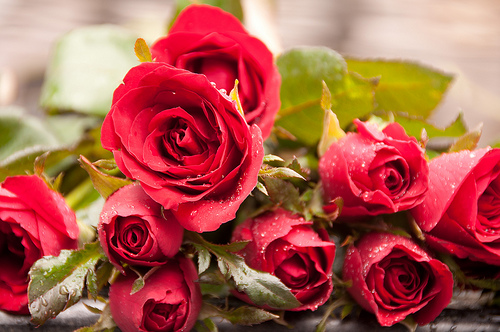

In [132]:
Image.open(list(roses.glob('*.*'))[5])



use preprocessing

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                  horizontal_flip= True,
                                                                  vertical_flip= True,
                                                                  rotation_range= 5,#180 BAD IDEA
                                                                  zoom_range = .1)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
image_count = len(list(flowers_dir.glob('*/*.jpg')))
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [140]:
list(CLASSES)

['roses', 'daisy', 'dandelion', 'tulips', 'sunflowers']

In [168]:
train_data_generator = image_generator.flow_from_directory(str(flowers_dir) , 
                                                           batch_size = BATCH_SIZE,
                                                           classes = list(CLASSES),
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT,IMG_WIDTH))

Found 3670 images belonging to 5 classes.


In [142]:
for fl , lab in next(train_data_generator):
  

(array([[[[2.42766723e-01, 1.39459640e-01, 2.83094049e-02],
          [2.41811767e-01, 1.39077663e-01, 2.85003949e-02],
          [2.40856826e-01, 1.38695672e-01, 2.86913831e-02],
          ...,
          [7.00925231e-01, 6.22493804e-01, 4.86274540e-01],
          [6.55904889e-01, 5.79861820e-01, 4.52838331e-01],
          [5.77677488e-01, 5.00610828e-01, 3.72563690e-01]],
 
         [[2.58851022e-01, 1.47072569e-01, 2.45029405e-02],
          [2.58087039e-01, 1.46690592e-01, 2.46939305e-02],
          [2.57323086e-01, 1.46308616e-01, 2.48849206e-02],
          ...,
          [7.00214267e-01, 6.21782899e-01, 4.86274540e-01],
          [6.53061032e-01, 5.77195704e-01, 4.50349957e-01],
          [5.73944986e-01, 4.96700495e-01, 3.68475646e-01]],
 
         [[2.20251068e-01, 1.32021993e-01, 2.63623502e-02],
          [2.23115921e-01, 1.33167952e-01, 2.61713583e-02],
          [2.25980759e-01, 1.34313881e-01, 2.59803701e-02],
          ...,
          [6.99503243e-01, 6.21071875e-01, 4.8627

In [152]:
CLASSES[[0., 0., 0., 0., 1.].index(1)]

'sunflowers'

In [0]:
## show a batch of 25 img 

def show_batch(image_batch , label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASSES[list(label_batch[n]).index(1)])
    plt.axis('off')

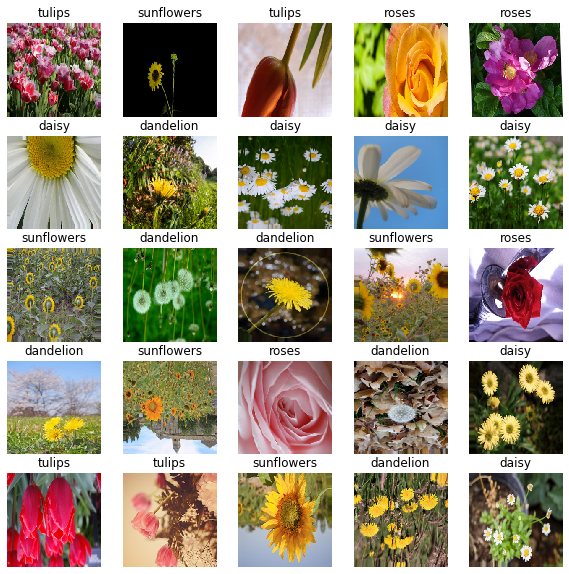

In [170]:
image_batch, label_batch = next(train_data_generator)
show_batch(image_batch, label_batch)

this is quite slow compared to 